## Migen Nodes

MigenNodes leverage the migen framework to define logic that can compiled and executed on FPGAs.
For more detail about the migen project please refer to https://github.com/m-labs/migen.
Before introducing the node, few important points about FPGA logic. 

### Combinatorial vs Sequential (clocked) logic

The logic that composes an FPGA can be decomposed in a large number of blocks that change
their status (and their output) as a function of their input(s).
An important distinction is between combinatorial logic and sequential logic.
Blocks implemented using the former logic generate a change in their output as
soon as an input changes.
Blocks instead implemented via sequential logic will propagate the change when a global
signal (normally called clk or sys_clk) transitions from one value to another
(normally from 0 to 1 - also known as rising edge transition).
It is important to specify a value for each signal in different sequential scenarios, typically
in each FSM state or an If/Else condition if that value is meant to be different than 0. 

### Inputs and output behaviour

FPGAs don't have the concept of `None` for an input and output.
The logic that composes the FPGA will always produce a value of 0 or 1 to the pins of the chip
(exceptions are high-impedance values that we won't discuss here).
This applies for input pins as well.

In order to connect to other via asynctonous channel and also be able to handle `None` we have implemented **protocol adapters**.
A protocol adapter relies on extra signals to indicate that the input or the output values should be considered valid.
Furthermore, because hardware can be busy processing the inputs or outputting the outputs to the outside
world we have ready signals on input and output ports.
The designer should keep in mind this when implementing the input and output portion of the block.

Let's start by importing the libraries needed


In [17]:
import logging

from migen import Signal, FSM, If, NextValue, NextState

import deltalanguage as dl

### Example 1: simple wire

All MigenNode inherit from `MigenNodeTemplate` and must implement the `migen_body` method.
In the initial part we define inputs and outputs of the node.
In this example we will simply take an input and send it out as an output.

**Note that all inputs have to be optional, i.e. use `Optional`.
This is default behaiviour for hardware simulation.**

In [18]:
class ExampleInOut(dl.MigenNodeTemplate):

     def migen_body(self, template):
          # Use this method of constructing I/O
          in1 = template.add_pa_in_port('in1', dl.Optional(int))
          out1 = template.add_pa_out_port('out1', int)

          # Example internal logic.

          # Declaring the input to be ready for receiving
          self.comb += (
               in1.ready.eq(1)
          )

          # Sending the input to the output.
          # Output data is valid when received on the input.
          self.comb += (
               out1.data.eq(in1.data),
               out1.valid.eq(in1.valid)
          )

Both ports `in1` and `out1` have three properties:

- `data` - actual data
- `valid` - 1-bit flag showing that the data is valid
- `ready` - 1-bit flag indicating the readiness for data

They were created by `template.add_pa_in_port` and `template.add_pa_out_port`
which play a role of protocol adapters and bind the migen logic to input
and output buffers.

In the current version they are implemented like this
(see `MigenNodeTemplate.tb_generator` for implementation of
the testbench generator):

- inputs
    - in order to permit receiving `data` the user must define the input's `ready` to 1
    - if yes, then `data` message can be received, buffered, and its `valid` becomes 1
    - if no, the input is not received
- outputs
    - always has `ready` as 1
    - on sending `data` the user must define its `valid` to 1
    - if yes, `data` will be buffered and sent out from the nodes
    - if no, `data` will stay in the testbench

To see the block in action, we must put it in a graph, let's define some helper nodes:

In [19]:
# this node will exit if receives 1+,
# otherwise just prints on the screen
s = dl.lib.StateSaver(int, verbose=True, condition=lambda x: x >= 1)

Now, define the graph:

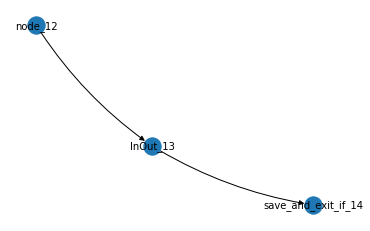

In [20]:
migen = ExampleInOut(name='InOut')

with dl.DeltaGraph() as graph:
    migen_out = migen.call(in1=1)
    s.save_and_exit_if(migen_out.out1)

graph.draw(seed=1)

This _looks_ good, so we can run this graph in the simulator:

In [21]:
rt = dl.DeltaPySimulator(graph)
rt.run()

# check the result
assert s.saved[-1] == 1

saving 1


### Example 2: counter

Let's now make a tiny bit more complex application of a migen node.
We want to generate a sequence `0, 1, 2, ..., 2**N` and send it to the outside world when our input is valid.
To give enough time to a real hardware node to send the data will change the value of the output every
clock cycle (with a sync block).

Also we add this `migen.Signal` to the debugging dictionary to
caprute the internal behaiviour:

In [23]:
CNT_SIZE = 10


class ExampleCountOut(dl.MigenNodeTemplate):

     def migen_body(self, template):
          # I/O:
          in1 = template.add_pa_in_port('in1', dl.Optional(int))
          out1 = template.add_pa_out_port('out1', int)

          # Logic:
          self.comb += (
               in1.ready.eq(1),
               out1.ready.eq(1)
          )

          # 10-bit counter - [0, 2**CNT_SIZE - 1]
          self.cnt = Signal(CNT_SIZE)

          # Incrementing the counter of 1 per clock cycle
          self.sync += self.cnt.eq(self.cnt+1)

          # Sending the input to the output. Data will be valid on
          # the output when received on the inpuy  
          self.comb += (
               out1.data.eq(self.cnt),
               out1.valid.eq(in1.valid)
          )

          # To add the internal Signal to debugging, add a new
          # value to the dictionary, in the following form:
          # Tuple[migen.Signal, str], where str is number format
          #
          # Ref: https://mkaz.blog/code/python-string-format-cookbook/
          template.debug_signals['cnt'] = (self.cnt, f'0{CNT_SIZE}b')

If we now define the following graph, note that we change the logging level
in order to see the debugged signal:

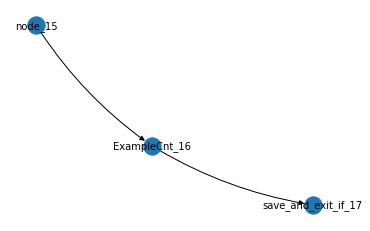

In [24]:
s = dl.lib.StateSaver(int, verbose=True, condition=lambda x: x >= 10)
migen = ExampleCountOut(name='ExampleCnt', lvl=logging.DEBUG)

with dl.DeltaGraph() as graph:
    migen_out = migen.call(in1=1)
    s.save_and_exit_if(migen_out.out1)

graph.draw(seed=1)

Let's run the graph, the debugging messages printed after each migen iteration.

Find the debugged signal and check that that it increments at each iteration
as expected:

In [25]:
rt = dl.DeltaPySimulator(graph)
rt.run()

print (f"Value of cnt inside migen node {migen.out_buffer}")

assert s.saved[-1] == 10

PythonNode ExampleCnt_16 [INFO]: <- {'in1': 1}
PythonNode ExampleCnt_16 [DEBUG]: Running...
ExampleCnt [DEBUG]: start iteration 0
ExampleCnt [DEBUG]: all _dut.in_ports ready: True
ExampleCnt [DEBUG]: inputs available: True
ExampleCnt [DEBUG]: writing in_port name=in1 valid=1, data=1
ExampleCnt [DEBUG]: out_ports set ready
ExampleCnt [DEBUG]: retrieved data output=None
ExampleCnt [DEBUG]: end of iteration 0
ExampleCnt [DEBUG]: <<<<<<<<<<< STATUS AFTER YIELD IN ITER 0
ExampleCnt [DEBUG]: self.in_buffer={'in1': 1}
ExampleCnt [DEBUG]: in_ports:
ExampleCnt [DEBUG]: name='in1': data=1 valid=1 ready=1
ExampleCnt [DEBUG]: debug_signals:
ExampleCnt [DEBUG]: name='cnt': 0000000001
ExampleCnt [DEBUG]: out_ports:
ExampleCnt [DEBUG]: name='out1': data=1 valid=1 ready=1
ExampleCnt [DEBUG]: self.out_buffer=None
ExampleCnt [DEBUG]: >>>>>>>>>>>
ExampleCnt [DEBUG]: start iteration 1
ExampleCnt [DEBUG]: all _dut.in_ports ready: True
ExampleCnt [DEBUG]: inputs available: True
ExampleCnt [DEBUG]: writing i

AttributeError: 'int' object has no attribute 'out1'

This time we should stop when the output becomes bigger than 10.
Because we have implemented no feedback the counter inside the migen node will carry on incrementing until
`DeltaPySimulator` exits.
Remember nodes are simulated/ran asynchronously and independently so the internal value of `self.sync` will be
likely higher than 10.

### Example 3: Finite State Machine

Building on the previous example we want to have a state machine that stops to increment when we reach the value of 10.
Note: It is important to specify a value for each signal in each state of the FSM. If no value is provided, Migen will assign a 0 to it. In this example, we set `NextValue(self.cnt, self.cnt)` to keep the value of `self.cnt` in the `DONE` state. This is an artifcat of Migen when it generates verilog code.

In [9]:
class ExampleCountOutFSM(dl.MigenNodeTemplate):

     def migen_body(self, template):
          # I/O:
          in1 = template.add_pa_in_port('in1', dl.Optional(int))
          out1 = template.add_pa_out_port('out1', int)
                    
          # Logic:
          self.comb += (
               in1.ready.eq(1),
          )

          # counter
          self.cnt = Signal(10)

          # Defining a state machine with three states -
          # IDLE, COUNTING and DONE. We will start IDLE from 
          # powerup of the system
          self.submodules.CMD_fsm = FSM(reset_state='IDLE')

          # In the IDLE we wait for the first valid input and
          # then we move to COUNTING 
          self.CMD_fsm.act('IDLE', 
               If(in1.valid == 1,
                    NextValue(self.cnt, 0),
                    NextState('COUNTING')
               )
          )
          # In COUNTING we count up to 10 and then move to DONE
          self.CMD_fsm.act('COUNTING', 
               If(self.cnt == 10,
                    NextValue(self.cnt, self.cnt),
                    NextState('DONE')
               ).Else(
                    NextValue(self.cnt, self.cnt+1),
               )
          )
          # In DONE we do nothing
          self.CMD_fsm.act('DONE',
               # this line sets the counter to its previous value
               # which is different from the migen's default value (0)
               NextValue(self.cnt, self.cnt)
          )

          # Sending the input to the output. Data will be valid on
          # the output when received on the inpuy  
          self.comb += (
               out1.data.eq(self.cnt),
               out1.valid.eq(in1.valid)
          )

We now create the graph as before:

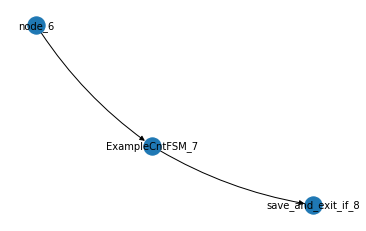

In [10]:
s = dl.lib.StateSaver(int, verbose=True, condition=lambda x: x >= 10)
migen = ExampleCountOutFSM(name='ExampleCntFSM')
with dl.DeltaGraph() as graph:
    migen_out = migen.call(in1=1)
    s.save_and_exit_if(migen_out.out1)

graph.draw(seed=1)

And run:

In [11]:
rt = dl.DeltaPySimulator(graph)
rt.run()

print (f"Value of cnt inside migen node {migen.out_buffer}")

assert s.saved[-1] == 10

saving 0
saving 0
saving 1
saving 2
saving 3
saving 4
saving 5
saving 6
saving 7
saving 8
saving 9
saving 10
Value of cnt inside migen node 10


If you now were to change the exit condition to `lambda x: x >= 11` instead of `lambda x: x >= 10`
the simulatro will never complete as the migen node will not generate a value greater than 10.

### Conclusion

There is much more to be said about how to work with FPGA but this should hopefully show that
simple logic around inputs and ouputs can be simply implemented.
In general, FPGAs are used to minimize latency and to significantly reduced bandwidth
requirements (by aggregating signals) of your systems.
Plus it is generally easier to implement real-time controls on FPGAs than on CPUs.